<h1 align='center' dir='rtl' style='color:yellow'>نام طرح</h1>

<h2 align='center' dir='rtl'>فراخوانی کتابخانه های مورد نیاز</h2>

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers import Dense, Input, Flatten, Conv2D, SimpleRNN, LSTM
from tensorflow.keras.models import Model
from tensorflow.keras.datasets import mnist

<h2 align='center' dir='rtl'> لود کردن دیتاست MNIST</h2>

In [2]:
train_set, test_set = mnist.load_data()

11490434/11490434 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


<h2 align='center' dir='rtl'>طراحی لایه های استخراج ویژگی و سنجش نسبت ها</h2>

<h3 align='center' dir='rtl'>لایه استخراج ویژگی</h3>

In [3]:
# لایه استخراج ویژگی
kernel_initializer = 'normal'
activation = "relu"

dtype = tf.float32


def get_module_1():
    shape=(28,28, 1)
    chs=1
    inputs = Input(shape)
    layer = Conv2D(filters=32*chs, kernel_size=(3,3), activation=activation, kernel_initializer=kernel_initializer)(inputs)
    layer = Conv2D(filters=16*chs, kernel_size=(3,3), strides=(2, 2), activation=activation, kernel_initializer=kernel_initializer)(layer)
    layer = Conv2D(filters=8*chs, kernel_size=(3,3), activation=activation, kernel_initializer=kernel_initializer)(layer)
    layer = Conv2D(filters=4*chs, kernel_size=(3,3), strides=(2, 2), activation='linear', kernel_initializer=kernel_initializer)(layer)
    layer = Conv2D(filters=64*2, kernel_size=(4,4), activation='softplus', kernel_initializer=kernel_initializer)(layer)
    layer = Flatten()(layer)
    model = Model(inputs, layer)

    return model

<h3 align='center' dir='rtl'>لایه سنجش نسبت ها</h3>

In [4]:
# لایه سنجش نسبت ها
def get_module_2():
    shape=(1, 64*2+10,)
    inputs = Input(shape)
    lstm1 = LSTM(64, return_sequences=True)(inputs)
    lstm2 = LSTM(32)(lstm1)
    outputs = Dense(10, activation='softmax')(lstm2)
    model = Model(inputs, outputs)
    return model

<h2 align='center' dir='rtl'>طراحی‌ و ساختن شبکه عصبی</h2>

In [22]:
def get_m2_input_vector(f0, f1, lbl1):
    # ترکیب ویژگی های کلاس مورد مطالعه با کلاس های دیگر

    inp = f0 * f1
    return tf.concat([inp, lbl1], axis=1)


class InfluenceModel(keras.Model):
    def __init__(self, module_1, module_2):
        super(InfluenceModel, self).__init__()
        #  لایه استخراج ویژگی
        self.module_1 = module_1
        # لایه تمام متصل (سنجش نسبت ها)
        self.module_2 = module_2

        self.loss = keras.losses.SparseCategoricalCrossentropy(from_logits=False)
        self.metric = keras.metrics.SparseCategoricalAccuracy()


    def compile(self, optimizer_1, optimizer_2):
        super(InfluenceModel, self).compile()
        self.optimizer_1 = optimizer_1
        self.optimizer_2 = optimizer_2

    def call_at_zero(self, x):
        # جدا کردن تصاویر
        imgs = x[0]
        # جدا کردن برچسب
        lbls = tf.one_hot(x[1], 10)

        # استخراج ویژگی های تصاویر
        features = self.module_1(imgs)

        n_feat = features.shape[0]
        # جدا سازی ویژگی های هر تصویر
        features = tf.split(features, n_feat, axis=0)

        # ویژگی های استحراج شده تصویر مورد مطالعه
        f0 = features[0]

        res_mtx = []
        res_row = []
        for j in range(1, n_feat):
            # ترکیب هر نمونه با تصویر مورد مطالعه
            f1 = features[j]
            lbl1 = lbls[j:j+1,:]
            inp = get_m2_input_vector(f0, f1, lbl1)

            res_row += [inp]

        # محاسبه نسبت هر نمونه با تصویر مورد مطالعه
        res_row = tf.concat(res_row, axis=0)
        res_row = tf.expand_dims(res_row, axis=1)
        res_mtx = self.module_2(res_row)

        # میانگین بر روی نمونه ها
        res = tf.reduce_sum(res_mtx, axis=0) / (n_feat-1)
        return res, res_mtx

    # Feed - Forward
    def call(self, x):
        # جدا کردن تصاویر
        imgs = x[0]
        # جدا کردن برچسب
        lbls = tf.one_hot(x[1], 10)

        # استخراج ویژگی های تصاویر
        features = self.module_1(imgs)

        # جدا سازی ویژگی های هر تصویر
        n_feat = features.shape[0]
        features = tf.split(features, n_feat, axis=0)


        res_mtx = []
        # ساخت جفت های ترکیب شده به ازای هر تصویر برای اموزش مدل
        for i in range(n_feat):
            res_row = []
            for j in range(n_feat):
                f0 = features[i]
                f1 = features[j]
                lbl1 = lbls[j:j+1,:]
                inp = get_m2_input_vector(f0, f1, lbl1)
                res_row += [inp]
            res_row = tf.concat(res_row, axis=0)
            res_row = tf.cast(res_row, dtype=tf.float32)
            res_row = tf.expand_dims(res_row, axis=1)
            # محاسبه سنجش تاثیر حضور تصاویر دیگر در پیش بینی تصویر مورد مطالعه
            res_mtx += [self.module_2(res_row)]

        res_mtx = tf.stack(res_mtx)
        #
        res_mtx = tf.transpose(res_mtx, [2, 1, 0])
        #
        res_mtx -= tf.linalg.diag(tf.linalg.diag_part(res_mtx))
        #
        res_mtx = tf.transpose(res_mtx, [2, 1, 0])
        #
        res = tf.reduce_sum(res_mtx, axis=1) / (n_feat-1)

        return res, res_mtx

    def train_step(self, x):
        # تعریف تابع ضرر
        loss = keras.losses.SparseCategoricalCrossentropy(from_logits=False)

        # محاسبه گرادیان و اعمال گرادیان
        with tf.GradientTape() as tape_1, tf.GradientTape() as tape_2:
            output, _ = self.call(x)
            loss_batch = loss(x[1], output)
        gradient_1 = tape_1.gradient(loss_batch, self.module_1.trainable_variables)
        self.optimizer_1.apply_gradients(zip(gradient_1, self.module_1.trainable_variables))
        gradient_2 = tape_2.gradient(loss_batch, self.module_2.trainable_variables)
        self.optimizer_2.apply_gradients(zip(gradient_2, self.module_2.trainable_variables))

        # اعمال معیار ارزیابی
        metric_batch = self.metric(x[1], output)

        return {"loss": loss_batch, "metric": metric_batch}


<h2 align='center' dir='rtl'>اموزش مدل</h2>

<h3 align='center' dir='rtl'>اتصال لایه ها</h3>

In [6]:
m1 = get_module_1()
m2 = get_module_2()

model = InfluenceModel(m1, m2)

<h3 align='center' dir='rtl'>کامپایل کردن مدل</h3>

In [7]:
optimizer_1 = tf.optimizers.Adam(learning_rate=1e-3, beta_1=0.9)
optimizer_2 = tf.optimizers.Adam(learning_rate=1e-3, beta_1=0.9)

m1.compile(optimizer_1)
m2.compile(optimizer_2)
model.compile(optimizer_1, optimizer_2)


In [8]:
m1.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)             │ (None, 28, 28, 1)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d (Conv2D)                      │ (None, 26, 26, 32)          │             320 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 12, 12, 16)          │           4,624 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 10, 10, 8)           │           1,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_3 (Conv2D)                    │ (None, 4, 4, 4)             │             292 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_4 (Conv2D)                    │ (None, 1, 1, 128)           │           8,320 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 128)                 │               0 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 14,716 (57.48 KB)

 Trainable params: 14,716 (57.48 KB)

 Non-trainable params: 0 (0.00 B)

In [9]:
m2.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)           │ (None, 1, 138)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm (LSTM)                          │ (None, 1, 64)               │          51,968 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_1 (LSTM)                        │ (None, 32)                  │          12,416 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 10)                  │             330 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 64,714 (252.79 KB)

 Trainable params: 64,714 (252.79 KB)

 Non-trainable params: 0 (0.00 B)

<h3 align='center' dir='rtl'>اموزش مدل</h3>

In [10]:
model.fit(train_set[0], train_set[1], epochs=3, batch_size=32)

Epoch 1/3
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 437s 126ms/step - loss: 0.3255 - metric: 0.8450
Epoch 2/3
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 252s 121ms/step - loss: 0.0815 - metric: 0.9786
Epoch 3/3
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 272s 127ms/step - loss: 0.0633 - metric: 0.9833


<h2 align='center' dir='rtl'>اماده سازی نمونه ها و محاسبه اهمیت هر نمونه نسبت به حضور دیگر نمونه ها</h2>

In [23]:
def get_samples(sample_ind, batch_size=64):

    # اماده سازی نمونه ها
    sample_image = test_set[0][sample_ind:sample_ind+batch_size,...]
    sample_label = test_set[1][sample_ind:sample_ind+batch_size,...]
    return sample_image, sample_label

In [24]:
def get_imporance_function(sample_ind):
    loss_fnc = tf.keras.losses.SparseCategoricalCrossentropy(reduction='none', from_logits=False)
    img, lbl = get_samples(sample_ind, 1)
    def get_batch_importance(batch_ind, batch_size=64):
        sample_images, sample_labels = get_samples(batch_ind, batch_size)
        sample_images = np.concatenate([img, sample_images])
        sample_labels = np.concatenate([lbl, sample_labels])

        probs_vec, probs_mtx = model.call_at_zero([sample_images, sample_labels])
        samples = probs_mtx.numpy()
        probs_vec = probs_vec.numpy()

        m = samples.mean(axis=0)

        # حذف نمونه مورد مطالعه و مشاهده تاثیر حضور دیگر نمونه و عدم حضور نمونه بر پیس بینی
        sample_output = samples.sum(axis=0, keepdims=True) - samples
        sample_output = sample_output/(batch_size-1)
        loss_with_sample = loss_fnc(lbl, m)
        loss_without_sample = loss_fnc(tf.repeat(lbl[tf.newaxis, ...], repeats=batch_size, axis=0), sample_output)
        sample_importance = loss_with_sample-loss_without_sample
        return sample_images[1:,...], sample_importance, probs_vec, samples
    return get_batch_importance, img, lbl

In [25]:
batch_ind = 5888
batch_ind = 4498
batch_ind = 1522
batch_ind = 625
batch_ind = 9698

batch_size = 64

batch_ind = batch_ind+1

sample_ind = batch_ind-1
importance_function_batch, img, lbl = get_imporance_function(sample_ind)
sample_images, importance, probs_vec, sample_output = importance_function_batch(batch_ind)

(64, 1, 138)


<h2 align='center' dir='rtl'>مشاهده تاثیر دیگر نمونه ها بر پیش بینی مدل</h2>

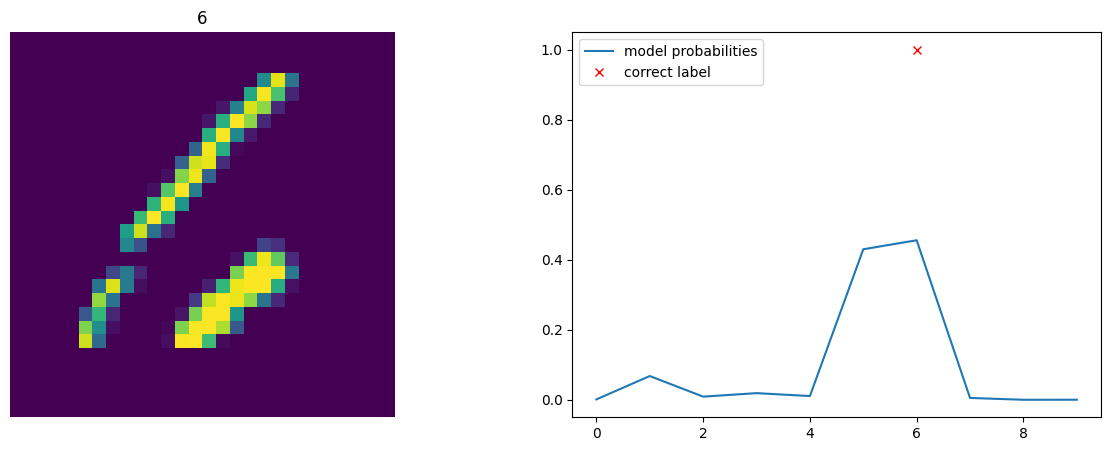

In [26]:
plt.figure(figsize=(15,5))
plt.subplot(121)
plt.imshow(img[0])
plt.title(lbl[0])
plt.axis('off')

plt.subplot(122)
plt.plot(probs_vec, label='model probabilities')
plt.plot(lbl, 1, 'rx', label='correct label')
plt.legend()

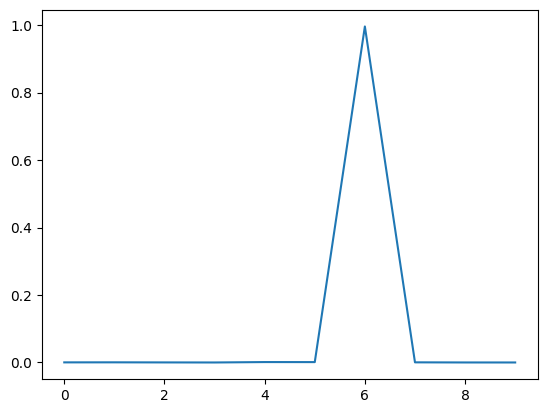

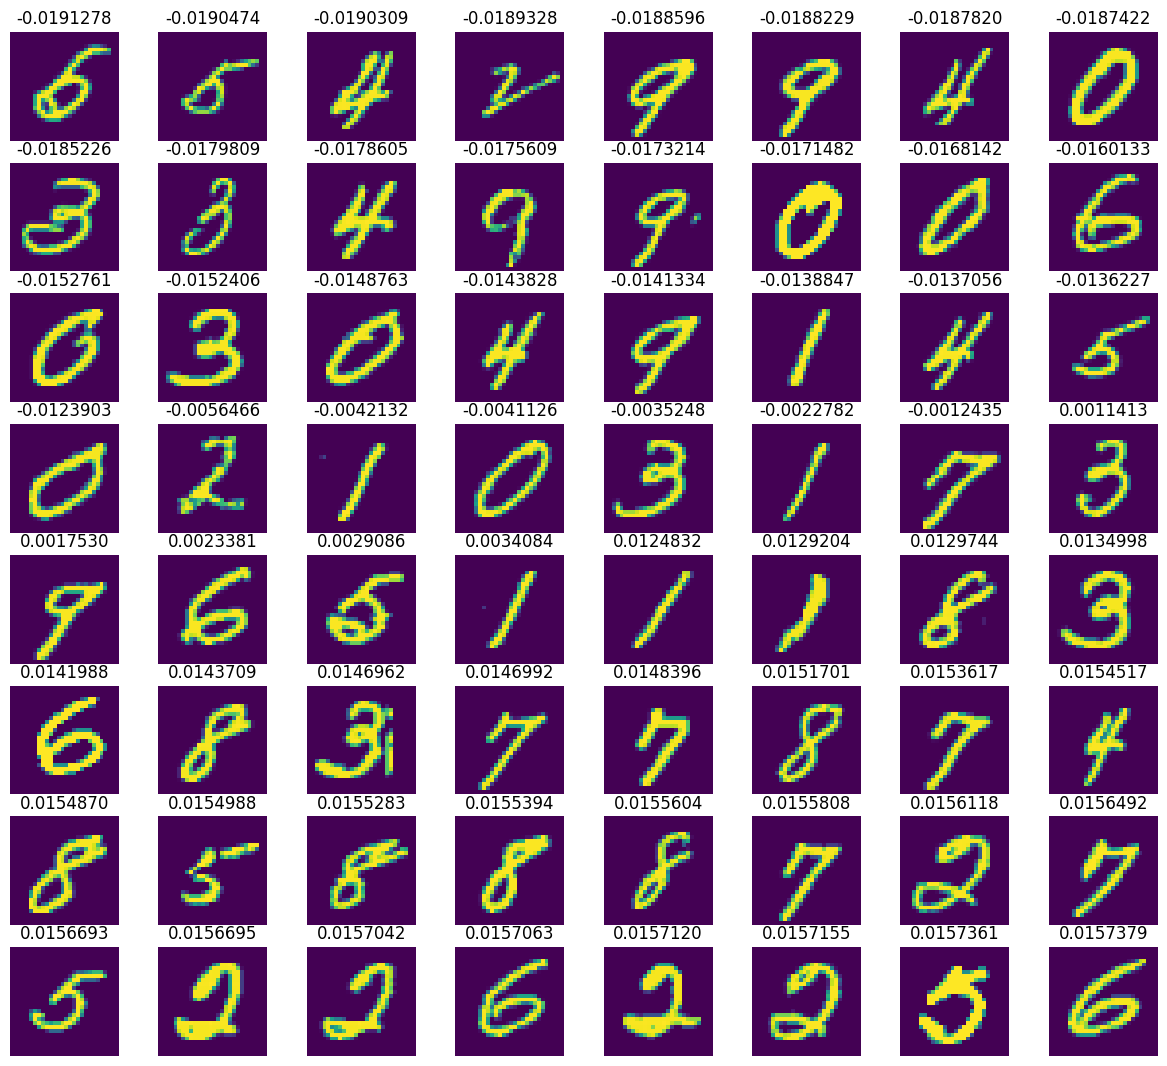

In [27]:
from matplotlib import pyplot as plt
import numpy as np

inds = np.argsort(importance)
plt.figure()
plt.plot(sample_output[inds[:5]].mean(axis=0))


plt.figure(figsize=(15,15))
for i in range(len(inds)):
    plt.subplot(batch_size//8+1, 8, i+1)
    plt.imshow(sample_images[inds[i],...])
    plt.title("%.7f"%(importance[inds[i]]))
    plt.axis('off')